In [4]:
import pandas as pd
import numpy as np

# Dataset'i yükle
df = pd.read_csv("diabetes_1.csv")

print("Veri boyutu:", df.shape)
df.head()


Veri boyutu: (100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
df = df.dropna()

df = pd.get_dummies(df, drop_first=True)

df.head()


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,6.6,80,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,5.7,158,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,5.0,155,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,4.8,155,0,True,False,True,False,False,False,False


In [6]:
print(df.columns)

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes', 'gender_Male', 'gender_Other',
       'smoking_history_current', 'smoking_history_ever',
       'smoking_history_former', 'smoking_history_never',
       'smoking_history_not current'],
      dtype='object')


In [7]:
y = df["diabetes"]
X = df.drop(columns=["diabetes"])


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y 
)

# ---- BURASI ÖNEMLİ: GPR için train datasını küçült ----
max_train = 3000   # 2000–5000 arası mantıklı, RAM’ine göre ayarla

if len(X_train) > max_train:
    idx = np.random.choice(len(X_train), size=max_train, replace=False)
    X_train_small = X_train.iloc[idx]
    y_train_small = y_train.iloc[idx]
else:
    X_train_small = X_train
    y_train_small = y_train

print("GPR için kullanılacak train boyutu:", len(X_train_small))

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_small)
X_test_scaled = scaler.transform(X_test)


GPR için kullanılacak train boyutu: 3000


In [9]:
import numpy as np

max_train = 3000

# indexleri al
idx_pos = np.where(y_train == 1)[0]
idx_neg = np.where(y_train == 0)[0]

# orana göre seçim
ratio_pos = len(idx_pos) / len(y_train)
n_pos = int(max_train * ratio_pos)
n_neg = max_train - n_pos

idx_pos_sample = np.random.choice(idx_pos, size=n_pos, replace=False)
idx_neg_sample = np.random.choice(idx_neg, size=n_neg, replace=False)

idx_sample = np.concatenate([idx_pos_sample, idx_neg_sample])
np.random.shuffle(idx_sample)

X_train_small = X_train.iloc[idx_sample]
y_train_small = y_train.iloc[idx_sample]

print("Training sample distribution:", np.bincount(y_train_small.astype(int)))


Training sample distribution: [2745  255]


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_small)
X_test_scaled = scaler.transform(X_test)

# GP modeli
kernel = C(1.0) * RBF(1.0)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=True)
gpr.fit(X_train_scaled, y_train_small)


,kernel,1**2 * RBF(length_scale=1)
,alpha,0.01
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,0
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,None
,kernel__k1,1**2
,kernel__k2,RBF(length_scale=1)
,kernel__k1__constant_value,1.0


In [11]:
# Tahmin
y_pred, y_std = gpr.predict(X_test_scaled, return_std=True)

# Varsayılan threshold 0.5
y_pred_class = (y_pred > 0.5).astype(int)

print("ACC:", accuracy_score(y_test, y_pred_class))
print("F1 :", f1_score(y_test, y_pred_class))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

ACC: 0.90915
F1 : 0.03811540497617787
ROC-AUC: 0.8433148666023788


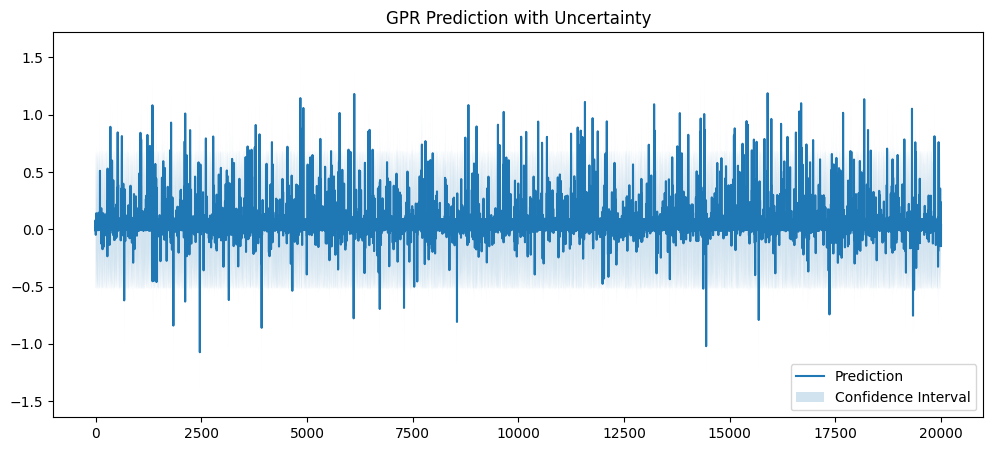

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_pred, label="Prediction")
plt.fill_between(
    range(len(y_pred)),
    y_pred - 1.96 * y_std,
    y_pred + 1.96 * y_std,
    alpha=0.2, label="Confidence Interval"
)
plt.title("GPR Prediction with Uncertainty")
plt.legend()
plt.savefig("GPR_Prediction_1.png")
plt.show()


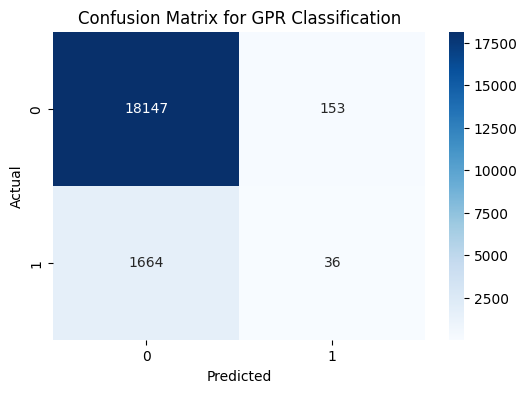

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for GPR Classification")
plt.savefig("ConfusionMatrix_1.png")
plt.show()


In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

thresholds = np.linspace(0.1, 0.6, 11)
f1_scores = []

for thr in thresholds:
    y_thr = (y_pred > thr).astype(int)
    f1_scores.append(f1_score(y_test, y_thr))

df_thr = pd.DataFrame({
    "Threshold": thresholds,
    "F1 Score": f1_scores
})

df_thr


,Threshold,F1 Score
0,0.10,0.242932
1,0.15,0.164940
2,0.20,0.126875
3,0.25,0.106631
4,0.30,0.085728
5,0.35,0.068493
6,0.40,0.050761
7,0.45,0.045762
8,0.50,0.038115
9,0.55,0.032241
